# Deep Learning Project

You have developed a model in your NLP session to predict the topic of tweets by examining the text content of the postings. In this project, you will create a model to classify the topic of pictures used in the tweets to help predict the topic of the tweets later. Your model from the NLP session and this one later can be used to predict a tweet's topic by examining both textual and the visual content of the postings.

You will first execute Step 1 to pull the images from the corresponding URL address of each image contained in the tweets. These images are already labeled manually by human editors in terms of whether the images belong to `Nature` topic or not. The label `1` means the image belongs to the nature topic and `2` means otherwise.

In Step 2, you will create a classification algorithm. Please divide the dataset into train and test datasets. You may use your train dataset to validate the accuracy of your model when tuning up the hyperparametrs of your model. After finalizing training your model, test it on your test dataset and report its accuracy. You may use different accuracy metrics.

### Step 0: Code to run notebook on Google Colab ###

In [1]:
!pip install "tensorflow_addons<0.21"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 2.5 MB/s eta 0:00:00


In [2]:
from zipfile import ZipFile
import os
import shutil
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
shutil.copy('/content/drive/My Drive/images.zip', '/content/images.zip')

with ZipFile("/content/images.zip", 'r') as zObject:
    zObject.extractall(path="/content/")

### Remaining code can be run natively as needed ###

## Step 1: Download the images


In [1]:
import urllib as ul
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import gc
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from sklearn.metrics import ConfusionMatrixDisplay
pd.options.mode.chained_assignment = None

g:\Programs\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
mypath = "./images"
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
rawdf = pd.read_csv("/content/tweet_data.csv")
rawdf

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
0,1070867471245164544,2018-12-07 02:27:55,-1,-1,98,False,True,False,64,https://pbs.twimg.com/media/Dtx8SiIWkAImVsb.jpg,34,-1,The immediate impulse for an alliance of the E...,Business,23464532,5988062,The Economist,NaN
1,1070868017888837633,2018-12-07 02:30:05,-1,-1,13,False,True,False,10,https://pbs.twimg.com/media/Dtx8yTyW4AEciqP.jpg,3,-1,America's economy is flashing some warning sig...,Business,1732809,16184358,CNN Business,NaN
2,1070868012864028673,2018-12-07 02:30:04,-1,-1,12,False,True,False,8,NaN,4,-1,Lyft files for what is expected to be one of t...,Business,2253989,25053299,FORTUNE,NaN
3,1070867995239555075,2018-12-07 02:30:00,-1,-1,5,False,True,False,4,NaN,1,-1,"Exporters still waiting to get Rs 6,000 crore ...",Business,1704056,43855487,Business Standard,NaN
4,1070867995205885952,2018-12-07 02:30:00,-1,-1,5,False,True,False,2,NaN,3,-1,Ride-hailing firm Lyft races to leave Uber beh...,Business,1997662,15110357,Reuters Business,https://video.twimg.com/amplify_video/10708116...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785911,1147325851614117888,2019-07-06 02:06:13,-1,-1,3,False,True,True,1,NaN,2,542154137,Relations are DIFFERENT\nnot DIFFICULT.,Motivational,85625,542154137,Wit & Wisdom 💯,NaN
785912,1153184058714624001,2019-07-22 06:04:39,-1,-1,867,False,True,True,561,https://pbs.twimg.com/media/EADuxohU8AAQo8G.jpg,306,858516111410647040,"""to live a creative life, we must lose our fea...",Interesting,208417,2920686840,DeepFeling™,NaN
785913,1153048802116292608,2019-07-21 21:07:11,-1,-1,4605,False,True,True,4253,NaN,352,3282859598,Who's your comic crush? https://t.co/H29dhXw3kf,Memes,7024207,436266454,Twitter Movies,https://video.twimg.com/amplify_video/11530474...
785914,1154063052997836801,2019-07-24 16:17:27,-1,-1,5638,True,True,False,4996,https://pbs.twimg.com/media/EAQOObJWwAASaxj.jpg,642,-1,"After a flight of 195 hours, 18 minutes, 35 se...",Random,32030797,11348282,NASA,NaN


In [ ]:
revieweddf = rawdf[(rawdf["edInput"] != -1) & (rawdf["edInput"] != 3)]
revieweddf

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
721,1070970722598707200,2018-12-07 09:18:12,1,5001,5137,True,True,False,4180,https://pbs.twimg.com/media/DtzaMK_W4AE6Vle.jpg,957,-1,Which one would you choose? 👀 https://t.co/U0s...,Fashion,37293,1061553474918342656,Gentleman’s style,NaN
1374,1070981773616648193,2018-12-07 10:02:07,1,5003,52650,True,True,True,36349,NaN,16301,781427301472874497,How it’s made. 😊 https://t.co/3XjOw4gIkg,Interesting,34897,994950431234080768,Satisfying Slime,https://video.twimg.com/ext_tw_video/107097772...
1867,916500037818916866,2017-10-07 03:06:51,2,5003,63872,False,True,True,39698,NaN,24174,821811651393495040,"Smile, because it confuses people. Smile, beca...",Interesting,966840,482658470,Tips & Tricks Ideas ✌,NaN
2206,1071135340696625152,2018-12-07 20:12:20,1,5001,1714,True,True,False,1261,https://pbs.twimg.com/media/Dt1v6O9XgAIXOrR.jpg,453,-1,𝐶𝑙𝑎𝑢𝑑𝑒 𝑀𝑜𝑛𝑒𝑡 https://t.co/WdavWJcSyw,Art,33308,762649146,𝐴𝑟𝑡.,NaN
2263,1071141175606829056,2018-12-07 20:35:31,1,5001,62062,True,True,False,49073,NaN,12989,-1,Baby Alpacas are so under appreciated. https:/...,Animal,1052924,2828212668,Nature is Amazing ☘️,https://video.twimg.com/ext_tw_video/107114109...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785850,1153952965650079744,2019-07-24 09:00:01,1,5005,20,True,True,True,10,https://pbs.twimg.com/media/D_h05AQXYAArdka.jpg,10,3197789991,Apply for a grant to implement plant conservat...,Flowers,5430,8224502,BGCI,NaN
785854,1154059414174703617,2019-07-24 16:03:00,2,5004,79,False,True,True,64,NaN,15,20562637,Are you team Shake Shack or team In-N-Out? htt...,Business,214552,4805771380,FOOD INSIDER,https://video.twimg.com/amplify_video/10376357...
785863,1154061474383441920,2019-07-24 16:11:11,1,5007,8,True,True,True,7,https://pbs.twimg.com/media/EAQMyyyXkAAQocF.jpg,1,529501969,How @OlafurEliasson's 'hedonistic' dad helped ...,Art,57448,187869078,Phaidon,NaN
785871,1154130836217683968,2019-07-24 20:46:48,1,5007,15,True,True,True,9,NaN,6,314542577,I am delighted that @IfOnly and @Sothebys are ...,Art,102499,113509194,Alice Waters,NaN


In [ ]:
designdf = revieweddf[(revieweddf["topicName"] == "Design & Architecture") | (revieweddf["edInput"] != 2)]
designdf

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
721,1070970722598707200,2018-12-07 09:18:12,1,5001,5137,True,True,False,4180,https://pbs.twimg.com/media/DtzaMK_W4AE6Vle.jpg,957,-1,Which one would you choose? 👀 https://t.co/U0s...,Fashion,37293,1061553474918342656,Gentleman’s style,NaN
1374,1070981773616648193,2018-12-07 10:02:07,1,5003,52650,True,True,True,36349,NaN,16301,781427301472874497,How it’s made. 😊 https://t.co/3XjOw4gIkg,Interesting,34897,994950431234080768,Satisfying Slime,https://video.twimg.com/ext_tw_video/107097772...
2206,1071135340696625152,2018-12-07 20:12:20,1,5001,1714,True,True,False,1261,https://pbs.twimg.com/media/Dt1v6O9XgAIXOrR.jpg,453,-1,𝐶𝑙𝑎𝑢𝑑𝑒 𝑀𝑜𝑛𝑒𝑡 https://t.co/WdavWJcSyw,Art,33308,762649146,𝐴𝑟𝑡.,NaN
2263,1071141175606829056,2018-12-07 20:35:31,1,5001,62062,True,True,False,49073,NaN,12989,-1,Baby Alpacas are so under appreciated. https:/...,Animal,1052924,2828212668,Nature is Amazing ☘️,https://video.twimg.com/ext_tw_video/107114109...
2660,1070988807514640384,2018-12-07 10:30:04,1,5001,78403,True,True,True,58396,NaN,20007,769254092581449728,For some people the idea of compassion entails...,Personal Development,18855031,20609518,Dalai Lama,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785847,1154126012105388032,2019-07-24 20:27:38,1,5005,31,True,True,True,25,https://pbs.twimg.com/media/EARHfeJUEAcyh52.jpg,6,15446126,Stylish Dog Toys from Wild One https://t.co/Gm...,Design & Architecture,12526,103090061,Dog Milk,NaN
785850,1153952965650079744,2019-07-24 09:00:01,1,5005,20,True,True,True,10,https://pbs.twimg.com/media/D_h05AQXYAArdka.jpg,10,3197789991,Apply for a grant to implement plant conservat...,Flowers,5430,8224502,BGCI,NaN
785863,1154061474383441920,2019-07-24 16:11:11,1,5007,8,True,True,True,7,https://pbs.twimg.com/media/EAQMyyyXkAAQocF.jpg,1,529501969,How @OlafurEliasson's 'hedonistic' dad helped ...,Art,57448,187869078,Phaidon,NaN
785871,1154130836217683968,2019-07-24 20:46:48,1,5007,15,True,True,True,9,NaN,6,314542577,I am delighted that @IfOnly and @Sothebys are ...,Art,102499,113509194,Alice Waters,NaN


In [ ]:
designpicsdf = designdf[designdf["photoUrl"].notna()]
designpicsdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99773 entries, 721 to 785872
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetID     99773 non-null  int64 
 1   crDate      99773 non-null  object
 2   edInput     99773 non-null  int64 
 3   editor      99773 non-null  int64 
 4   engages     99773 non-null  int64 
 5   isApproved  99773 non-null  bool  
 6   isEdNeed    99773 non-null  bool  
 7   isRT        99773 non-null  bool  
 8   likes       99773 non-null  int64 
 9   photoUrl    99773 non-null  object
 10  retweets    99773 non-null  int64 
 11  rtUsID      99773 non-null  int64 
 12  text        99773 non-null  object
 13  topicName   99773 non-null  object
 14  usFlwrs     99773 non-null  int64 
 15  usID        99773 non-null  int64 
 16  usName      99773 non-null  object
 17  videoUrl    0 non-null      object
dtypes: bool(3), int64(9), object(6)
memory usage: 12.5+ MB


In [ ]:
designpicsdf.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
721,1070970722598707200,2018-12-07 09:18:12,1,5001,5137,True,True,False,4180,https://pbs.twimg.com/media/DtzaMK_W4AE6Vle.jpg,957,-1,Which one would you choose? 👀 https://t.co/U0s...,Fashion,37293,1061553474918342656,Gentleman’s style,NaN
2206,1071135340696625152,2018-12-07 20:12:20,1,5001,1714,True,True,False,1261,https://pbs.twimg.com/media/Dt1v6O9XgAIXOrR.jpg,453,-1,𝐶𝑙𝑎𝑢𝑑𝑒 𝑀𝑜𝑛𝑒𝑡 https://t.co/WdavWJcSyw,Art,33308,762649146,𝐴𝑟𝑡.,NaN
4213,1071479506655944704,2018-12-08 18:59:56,1,5001,2006,True,True,False,1562,https://pbs.twimg.com/media/Dt6o7FfXcAEmNCY.jpg,444,-1,"Aroma Restaurant in Rome, Italy https://t.co/1...",Art,13688,159163599,🇮🇹,NaN
5613,1071784046060015616,2018-12-09 15:10:04,1,5001,5618,True,True,False,4718,https://pbs.twimg.com/media/Dt-95qDWkAIAaGy.jpg,900,-1,Which one is your favourite? https://t.co/qYzw...,Fashion,40533,1061553474918342656,Gentleman’s style,NaN
25165,1074669099110801408,2018-12-17 14:14:14,1,5001,5519,True,True,False,4506,https://pbs.twimg.com/media/Dun91pvW0AANmZJ.jpg,1013,-1,Summer looks 😎👌 https://t.co/HwaX0sUjU1,Fashion,50472,1061553474918342656,Gentleman’s style,NaN


In [ ]:
designpicsdf["edInput"] = designpicsdf["edInput"].replace(4, 1)
designpicsdf["topicName"].value_counts()

Design & Architecture       16469
Art                         12840
Photography                 11016
Cryptocurrency               8610
Technology                   5918
Motivational                 5703
News                         5481
Flowers                      4430
Space                        4300
Nature                       4115
Travel                       3877
Editorial Pics               3720
Animal                       3698
Memes                        2923
Business                     2422
Interesting                  1554
Mindfulness                   830
DIY & Craft                   726
Funny                         247
Nanotech                      201
World Leaders                 148
Fitness                        89
Science                        71
Humor                          66
Stocks                         61
Psychology                     51
Digital Media & Internet       48
Startup                        44
US News                        41
science       

In [ ]:
opener = ul.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
ul.request.install_opener(opener)
invalidurls = []
def imgretrieve(imgurl, imgname):
    try:
        ul.request.urlretrieve(imgurl, imgname)
    except:
        invalidurls.append((imgname, imgurl))

designpicsdf.apply(lambda x: imgretrieve(x["photoUrl"], "/content/images/design." + str(x.name) + ".jpg") if x["topicName"] == "Design & Architecture" and x["edInput"] == 1 else imgretrieve(x["photoUrl"], "/content/images/other." + str(x.name) + ".jpg"), axis=1)

len(invalidurls)

In [3]:
filenames = os.listdir(mypath)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

df = pd.DataFrame({'filename': filenames, 'category': categories})

df.head()

,filename,category
0,design.141595.jpg,design
1,design.141596.jpg,design
2,design.141597.jpg,design
3,design.141599.jpg,design
4,design.141656.jpg,design


In [4]:
df.category.value_counts(normalize=True)

other     0.85096
design    0.14904
Name: category, dtype: float64

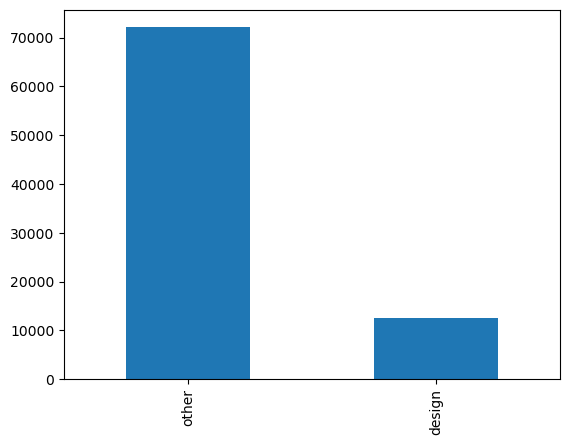

In [5]:
df.category.value_counts().plot.bar()
plt.show()

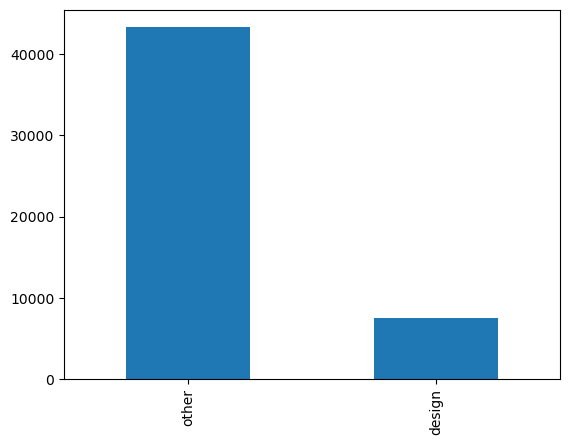

In [6]:
df_true = df[df["category"] == "design"]
df_false = df[df["category"] != "design"]
true_tv, true_test = train_test_split(df_true, test_size=0.2, random_state=42)
false_tv, false_test = train_test_split(df_false, test_size=0.2, random_state=42)
true_train, true_validate = train_test_split(true_tv, test_size=0.25, random_state=42)
false_train, false_validate = train_test_split(false_tv, test_size=0.25, random_state=42)
train_df = pd.concat([true_train, false_train]).sample(frac = 1)
validate_df = pd.concat([true_validate, false_validate]).sample(frac = 1)
test_df = pd.concat([true_test, false_test]).sample(frac = 1)
train_df.category.value_counts().plot.bar()
plt.show()

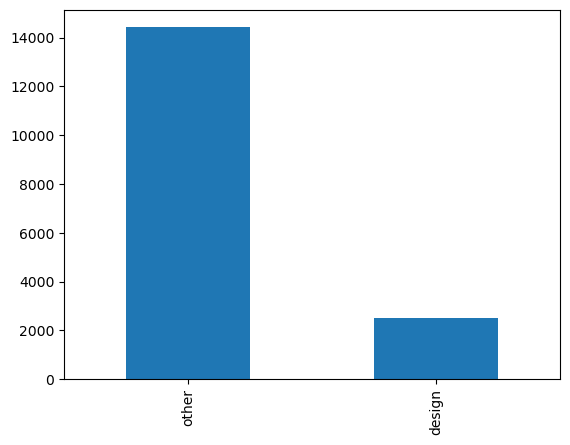

In [7]:
validate_df.category.value_counts().plot.bar()
plt.show()

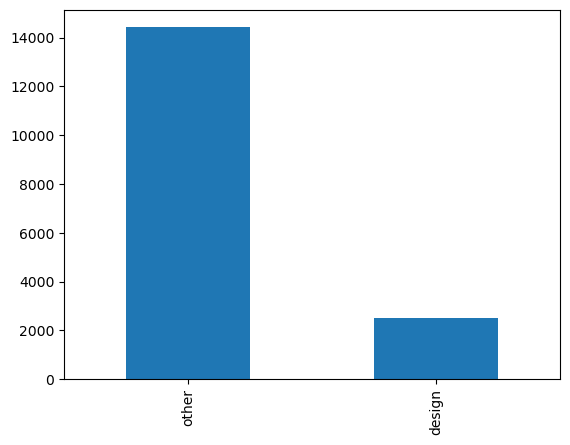

In [8]:
test_df.category.value_counts().plot.bar()
plt.show()

In [9]:
batch_size=16

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    mypath,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 50848 validated image filenames belonging to 2 classes.


In [10]:
train_generator.class_indices

{'design': 0, 'other': 1}

In [11]:
validation_datagen = test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    mypath,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 16950 validated image filenames belonging to 2 classes.


In [12]:
validation_generator.class_indices

{'design': 0, 'other': 1}

In [13]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    mypath,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

Found 16951 validated image filenames belonging to 2 classes.


In [14]:
test_generator.class_indices

{'design': 0, 'other': 1}

## Step 2: Classifier

Develop a classifier for two categories. Create the necessary folders for the test and train datasets. Either create your own model or tranfer a model and revise it. Make sure you incorporate regularization, callbacks, etc., and use data augmentation. Since images may not be so distinct with respect to their categories, you may not get the same kind of performance you had in your assignments.

In [15]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
for i in base_model.layers:
    i.trainable = False
    print(i.__class__.__name__, "=", i.trainable)

InputLayer = False
Conv2D = False
Conv2D = False
MaxPooling2D = False
Conv2D = False
Conv2D = False
MaxPooling2D = False
Conv2D = False
Conv2D = False
Conv2D = False
MaxPooling2D = False
Conv2D = False
Conv2D = False
Conv2D = False
MaxPooling2D = False
Conv2D = False
Conv2D = False
Conv2D = False
MaxPooling2D = False


In [16]:
model = Sequential(base_model)

model.add(Flatten())

model.add(Dense(512, activation="relu"))

model.add(BatchNormalization())

model.add(Dense(128, activation="relu"))

model.add(BatchNormalization())

model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[F1Score(num_classes=2, average="micro", threshold=0.15)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [ ]:
earlystop = EarlyStopping(patience=5, monitor="val_f1_score", mode="max")
filepath="/content/drive/My Drive/twitterbest.hdf5"
learning_rate_reduction = ReduceLROnPlateau(monitor='val_f1_score', patience=2, verbose=1, factor=0.2, min_lr=0.00001, mode="max")
checkpoint = ModelCheckpoint(filepath, monitor='val_f1_score', verbose=1, save_best_only=True, mode="max")

class MyCustomCallback(Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

callbacks = [checkpoint, learning_rate_reduction, earlystop, MyCustomCallback()]

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    steps_per_epoch=train_df.shape[0]//batch_size,
    callbacks=callbacks
)

Epoch 1/50
 571/4237 [===>..........................] - ETA: 28:51 - loss: 0.3300 - f1_score: 0.9327

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


4237/4237 [==============================] - ETA: 0s - loss: 0.2522 - f1_score: 0.9350
Epoch 1: val_f1_score improved from -inf to 0.94767, saving model to /content/drive/My Drive/twitterbest.hdf5
4237/4237 [==============================] - 2271s 533ms/step - loss: 0.2522 - f1_score: 0.9350 - val_loss: 0.2265 - val_f1_score: 0.9477 - lr: 0.0010
Epoch 2/50
4237/4237 [==============================] - ETA: 0s - loss: 0.2059 - f1_score: 0.9419
Epoch 2: val_f1_score improved from 0.94767 to 0.94919, saving model to /content/drive/My Drive/twitterbest.hdf5
4237/4237 [==============================] - 2239s 528ms/step - loss: 0.2059 - f1_score: 0.9419 - val_loss: 0.3285 - val_f1_score: 0.9492 - lr: 0.0010
Epoch 3/50
4237/4237 [==============================] - ETA: 0s - loss: 0.1768 - f1_score: 0.9482
Epoch 3: val_f1_score improved from 0.94919 to 0.95348, saving model to /content/drive/My Drive/twitterbest.hdf5
4237/4237 [==============================] - 2231s 526ms/step - loss: 0.1768 - 

In [17]:
testmodel = load_model("twitterbest.hdf5", compile=False)

testmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=[F1Score(num_classes=2, average="micro", threshold=0.15)])

testmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [18]:
testmodel.evaluate(test_generator, return_dict=True)

 500/1060 [=============>................] - ETA: 2:07 - loss: 0.2477 - f1_score: 0.9775

g:\Programs\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1060/1060 [==============================] - 244s 227ms/step - loss: 0.3065 - f1_score: 0.9795


{'loss': 0.30654266476631165, 'f1_score': 0.9795302748680115}

1060/1060 [==============================] - 239s 226ms/step


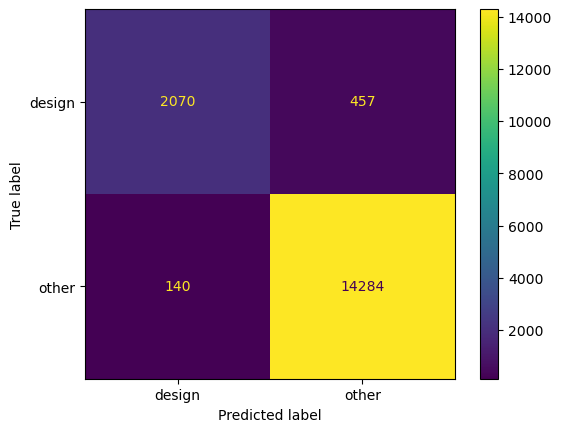

In [19]:
test_out = testmodel.predict(test_generator)
test_pred = pd.Series(test_out.flatten(), index=test_df.index).apply(lambda x: 0 if x <= 0.15 else 1).replace({v:k for k,v in test_generator.class_indices.items()})
confmatrix = ConfusionMatrixDisplay.from_predictions(test_df["category"], test_pred)
plt.show()

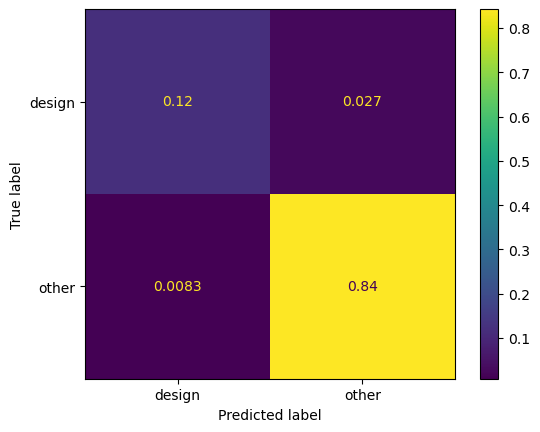

In [20]:
confmatrix = ConfusionMatrixDisplay.from_predictions(test_df["category"], test_pred, normalize="all")
plt.show()